<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

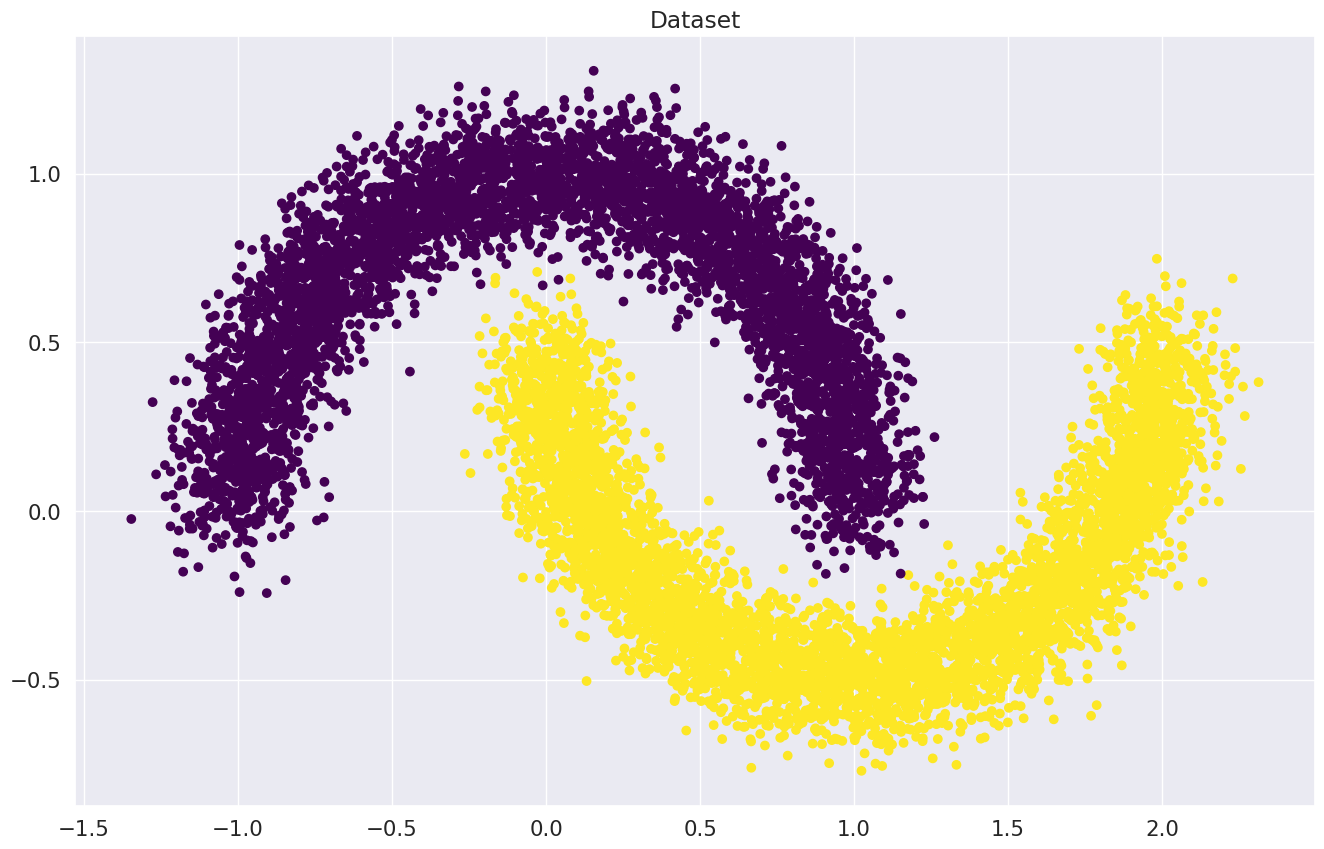

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)


### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train) # ЕСЛИ ВЫВЕСТИ X_train ... y_val то они будут типа float , поэтому переводим в тип Float.tensor
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)



Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)



## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

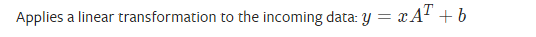

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features , in_features))
        self.bias = bias
        if bias:
            self.bias_term = torch.nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights.t()
        if self.bias:
            x +=  self.bias_term
        return x





In [27]:
linear_regression = LinearRegression(2,1 ) # 2 -  размерность X_batch , 1 - размерность outp , чтобы проверить можно вставить print(X_batch) в коде ниже
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)





**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [28]:

for parameter in linear_regression.parameters() :
    if parameter.requires_grad:
      print(parameter.name , parameter.data)

#Параметры модели (только те по которым можно взять градиент -> доступен backpropagation)



None tensor([[-1.1340,  0.4205]])
None tensor([1.8374])


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [15]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False


counter = 0 
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):

        

        optimizer.zero_grad()
        outp =  linear_regression(X_batch) 

        

        loss =  loss_function( outp , y_batch.view(-1,1) )
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)  # так как мы применять в качестве модели логистическую регрессию , то для перевода вероятностей в предсказания будем использовать функцию активации сигмойду .
        
        preds = (probabilities > 0.5).type(torch.long)
        
        
        
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break



Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.8671875
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8046875
Iteration: 800
Batch accuracy: 0.828125

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [16]:


print('Iterations :' , it + epoch * len(train_dataloader))

Iterations : 814


### Визуализируем результаты

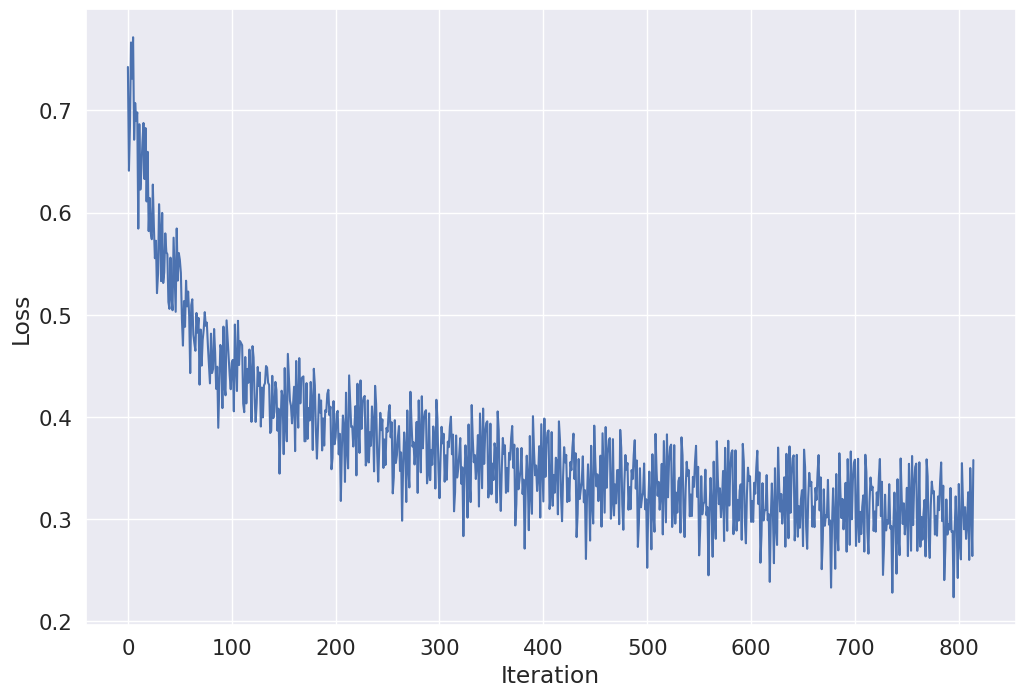

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

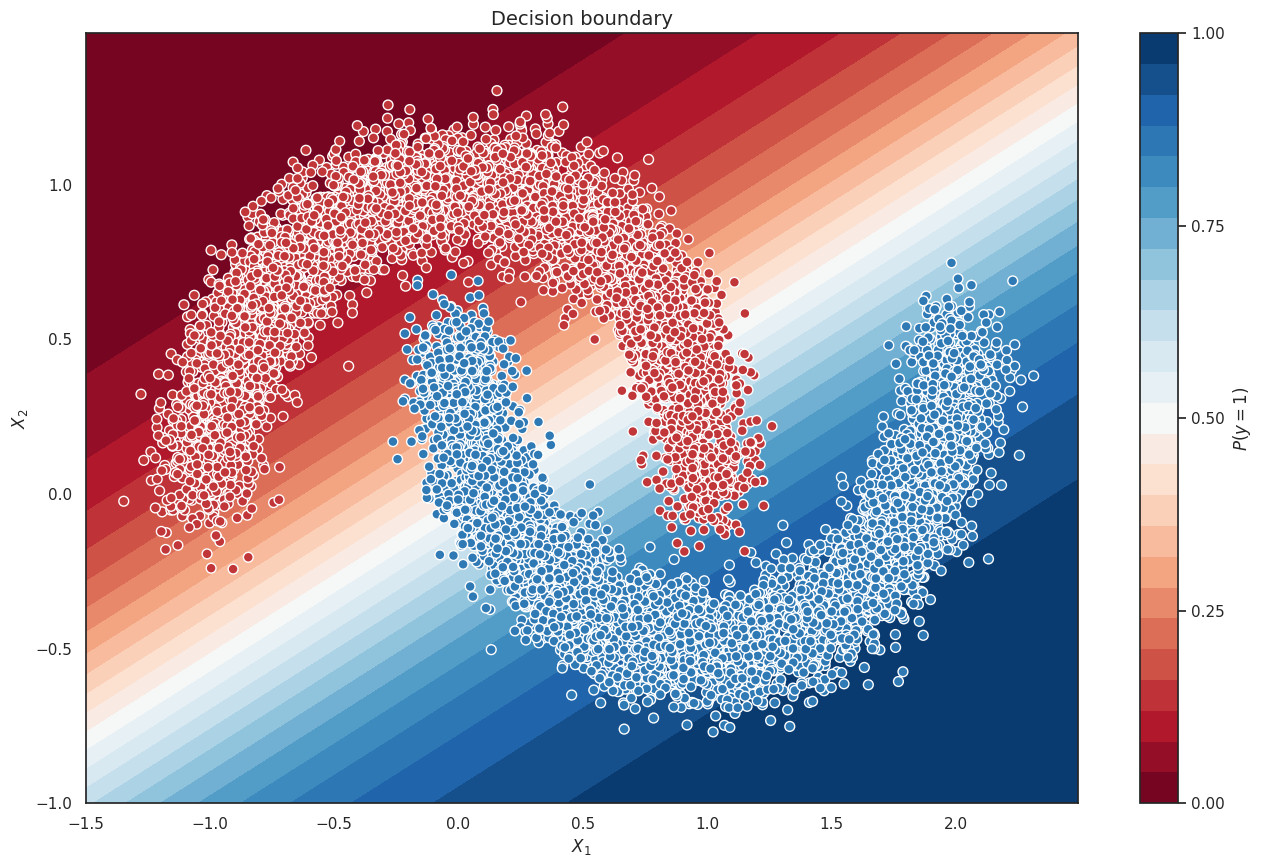

In [18]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [21]:


@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        
        preds = model(x_batch)
        preds = torch.sigmoid(preds)
        preds = ( preds > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [22]:
from sklearn.metrics import accuracy_score

val_pred = predict(val_dataloader , linear_regression)
val_pred = torch.Tensor(val_pred)

val_accuracy = accuracy_score( y_val_t , val_pred)


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [23]:

val_accuracy

0.8596

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [24]:
! pip3 install torchvision
import os
from torchvision.datasets import MNIST


import torchvision.transforms as tfs # Благодаря этому импорту будет работать tfs.Compose и картинки будут представляться не формате PIL , а в формате тензоров

data_tfs = tfs.Compose([
    tfs.ToTensor(), # Трансформацию изображения из PIL или другого формата в Tensor
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 16

train_dataloader =  DataLoader(train_dataset  , batch_size  = batch_size , shuffle = True )
valid_dataloader =  DataLoader( val_dataset , batch_size  = batch_size , shuffle = True   )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [25]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [26]:
train_dataset[0][0].shape # размерность каждого элемента из train dataset'a , 28 x 28 pixels 

torch.Size([1, 28, 28])

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [31]:
activation = nn.ELU

flat = nn.Flatten() # входной слой
linear1 = nn.Linear(28 * 28 , 128)
linear2 = nn.Linear(128 , 64) # 2 скрытых
linear3 = nn.Linear(64 , 10) # выходной слой 


model = nn.Sequential(
    flat  , 
    linear1 ,
    activation() , 
    linear2 , 
    activation() , 
    linear3

)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [34]:
from sklearn.metrics import accuracy_score

max_epochs = 10
accuracy = {"train": [ ], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
                 
            else:
                 model.eval()
                 with torch.no_grad(): 
                   outp = model(x_batch)
            
            preds = outp.argmax(-1)
            
           


            correct =  ( preds == y_batch).sum()

            
            all =  batch_size

            
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward() 
              optimizer.step() 
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9130666666666667
Loader: valid. Accuracy: 0.9478
Epoch: 2
Loader: train. Accuracy: 0.9568
Loader: valid. Accuracy: 0.9674
Epoch: 3
Loader: train. Accuracy: 0.9662166666666666
Loader: valid. Accuracy: 0.962
Epoch: 4
Loader: train. Accuracy: 0.9706166666666667
Loader: valid. Accuracy: 0.9677
Epoch: 5
Loader: train. Accuracy: 0.9750333333333333
Loader: valid. Accuracy: 0.9721
Epoch: 6
Loader: train. Accuracy: 0.9775666666666667
Loader: valid. Accuracy: 0.9714
Epoch: 7
Loader: train. Accuracy: 0.9793166666666666
Loader: valid. Accuracy: 0.9714
Epoch: 8
Loader: train. Accuracy: 0.9807666666666667
Loader: valid. Accuracy: 0.9712
Epoch: 9
Loader: train. Accuracy: 0.9827166666666667
Loader: valid. Accuracy: 0.9702
Epoch: 10
Loader: train. Accuracy: 0.9829333333333333
Loader: valid. Accuracy: 0.9759


In [35]:
accuracy

{'train': [0.9130666666666667,
  0.9568,
  0.9662166666666666,
  0.9706166666666667,
  0.9750333333333333,
  0.9775666666666667,
  0.9793166666666666,
  0.9807666666666667,
  0.9827166666666667,
  0.9829333333333333],
 'valid': [0.9478,
  0.9674,
  0.962,
  0.9677,
  0.9721,
  0.9714,
  0.9714,
  0.9712,
  0.9702,
  0.9759]}

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [36]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):  # Можно было реализовать по другому , но я решил скопировать код!
    

    
    act = activation

    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    act(),
    nn.Linear(128,64),
    act(),
    nn.Linear(64,10)
        )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())  
    
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [ ], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)      
                else:
                    model.eval()
                    with torch.no_grad(): 
                      outp = model(x_batch) 
                preds = outp.argmax(-1)
                correct =  ( preds == y_batch).sum()         
                all =  batch_size 
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward() 
                  optimizer.step() 
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    
    return accuracy['valid']

In [38]:
print('Plain Accuracy')   # Accuracy для всех функций активации

plain_accuracy = test_activation_function(Identical)

print('Relu accuracy')
relu_accuracy = test_activation_function(nn.ReLU)

print('Leaky relu accuracy')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

print('elu accuracy')
elu_accuracy = test_activation_function(nn.ELU)


Plain Accuracy
Epoch: 1
Loader: train. Accuracy: 0.8695333333333334
Loader: valid. Accuracy: 0.8832
Epoch: 2
Loader: train. Accuracy: 0.8911
Loader: valid. Accuracy: 0.8988
Epoch: 3
Loader: train. Accuracy: 0.89865
Loader: valid. Accuracy: 0.9116
Epoch: 4
Loader: train. Accuracy: 0.90375
Loader: valid. Accuracy: 0.8885
Epoch: 5
Loader: train. Accuracy: 0.9051333333333333
Loader: valid. Accuracy: 0.8929
Epoch: 6
Loader: train. Accuracy: 0.9086
Loader: valid. Accuracy: 0.9094
Epoch: 7
Loader: train. Accuracy: 0.9092166666666667
Loader: valid. Accuracy: 0.9152
Epoch: 8
Loader: train. Accuracy: 0.9097
Loader: valid. Accuracy: 0.8984
Epoch: 9
Loader: train. Accuracy: 0.9120333333333334
Loader: valid. Accuracy: 0.9093
Epoch: 10
Loader: train. Accuracy: 0.9117833333333333
Loader: valid. Accuracy: 0.9174
Relu accuracy
Epoch: 1
Loader: train. Accuracy: 0.9010833333333333
Loader: valid. Accuracy: 0.9457
Epoch: 2
Loader: train. Accuracy: 0.9503333333333334
Loader: valid. Accuracy: 0.9491
Epoch: 3

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

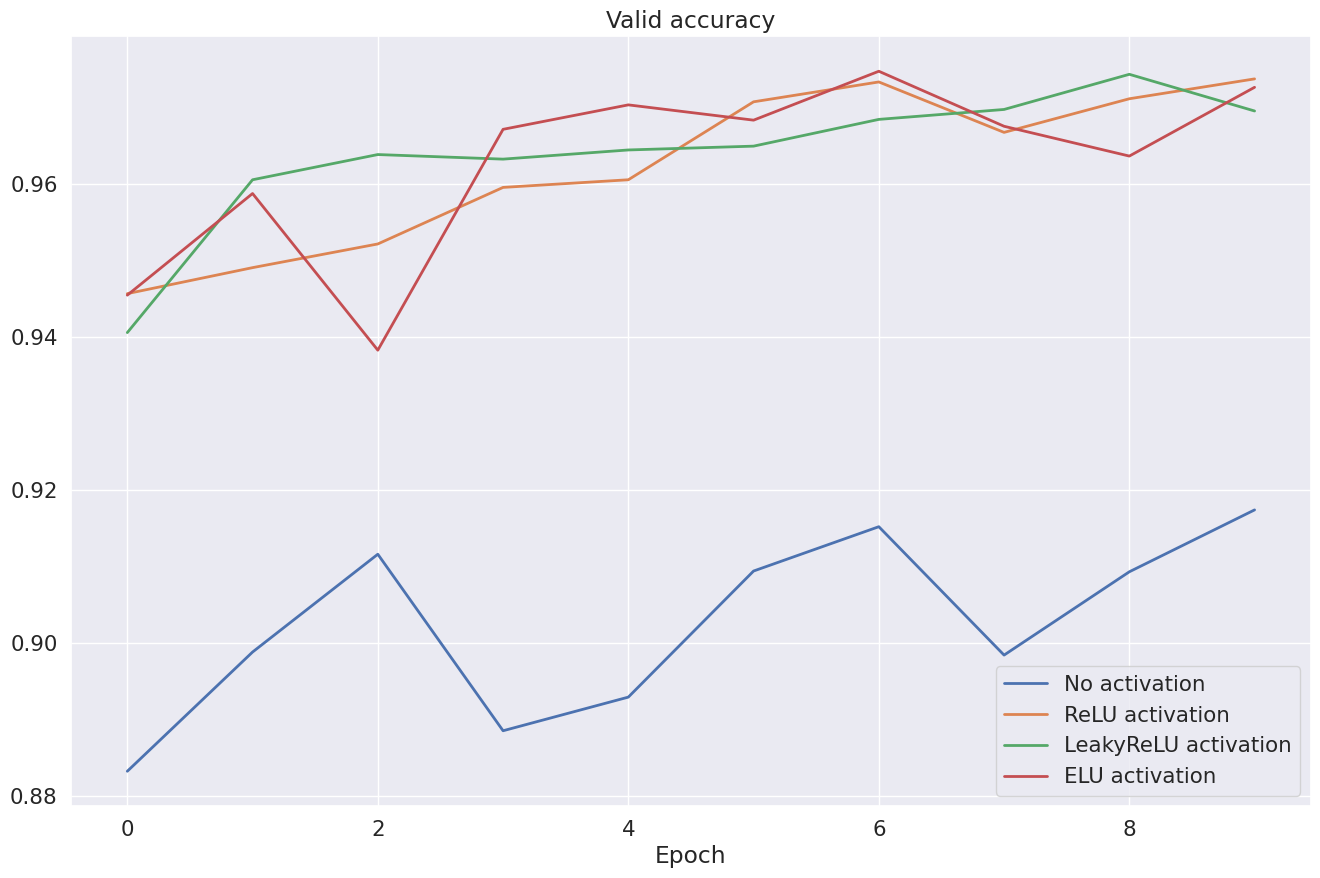

In [39]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

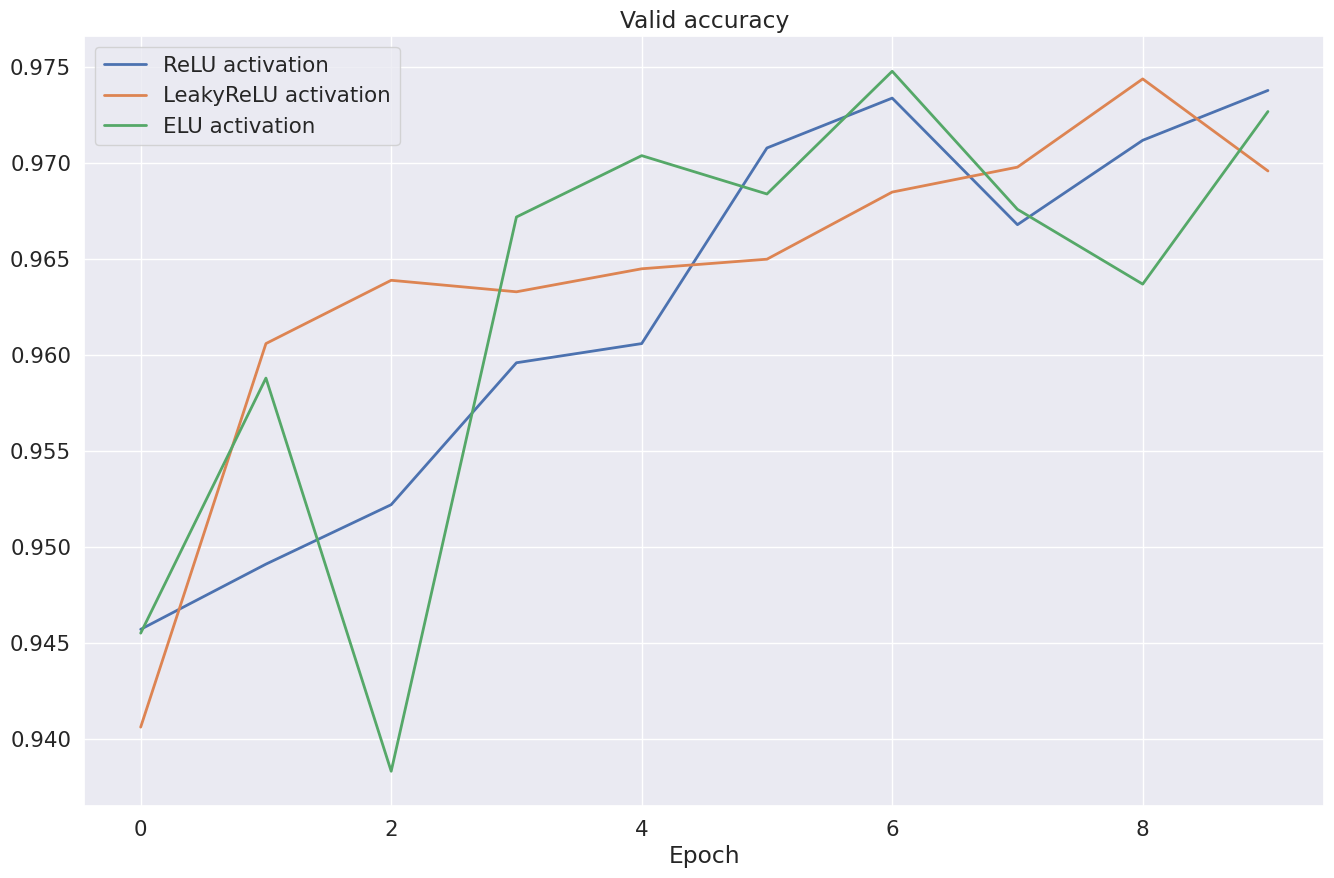

In [40]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [41]:
# Activation ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [42]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-01 18:26:38--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-01 18:26:38--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.01s   

2023-04-01 18:26:38 (4

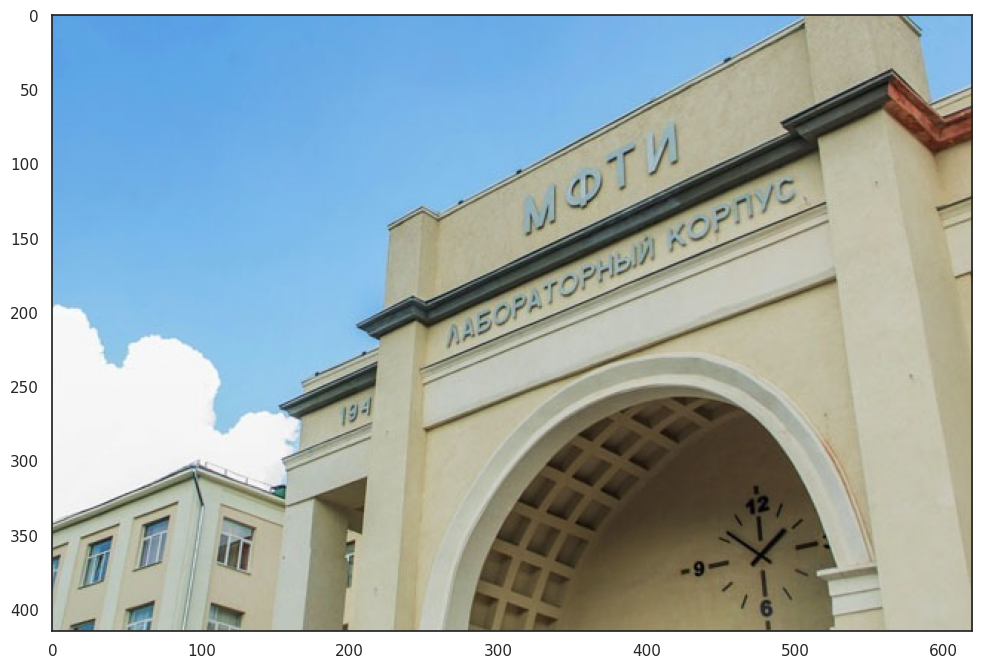

array([[[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [233, 188, 131],
        [233, 188, 131],
        [233, 188, 131]],

       [[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [234, 189, 132],
        [234, 189, 132],
        [233, 188, 131]],

       [[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [235, 190, 133],
        [234, 189, 132],
        [233, 188, 131]],

       ...,

       [[190, 198, 191],
        [190, 198, 191],
        [194, 199, 190],
        ...,
        [172, 196, 196],
        [174, 195, 196],
        [173, 194, 195]],

       [[188, 196, 189],
        [190, 199, 189],
        [197, 202, 193],
        ...,
        [172, 196, 196],
        [174, 195, 196],
        [173, 194, 195]],

       [[188, 197, 187],
        [189, 198, 188],
        [198, 203, 194],
        ...,
        [172, 196, 196],
        [173, 194, 195],
        [173, 194, 195]]

In [43]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()


img


Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [54]:
import matplotlib.pyplot as plt 


def f(k):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = k

    kernel = kernel.repeat(3, 3, 1, 1)


    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W] # поменять местами размерности




    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size # добавляет размерность к картинке чтобы после паддинга она осталось исходной размерности



    result = F.conv2d(img_t, kernel)[0]  # карта активации

    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

# Cоздадим функцию применения ядра к картинке 

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [55]:
kernels = {
    
'A'  : torch.tensor([ [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0] ] ).reshape(1, 1, 3, 3).type(torch.float32) , 


'Б' : torch.tensor([ [0, 1, 0],
      [0, -2, 0],
      [0, 1, 0] ] ).reshape(1, 1, 3, 3).type(torch.float32) , 


'В' : torch.tensor([ [0, 0, 0],
      [1, -2, 1],
      [0, 0, 0] ] ).reshape(1, 1, 3, 3).type(torch.float32) ,


'Г' : torch.tensor([ [0, 1, 0],
      [1, -4, 1],
        [0, 1, 0] ] ).reshape(1, 1, 3, 3).type(torch.float32) , 


'Д' : torch.tensor([ [0, -1, 0],
      [-1, 5, -1],
      [0, -1, 0]  ] ).reshape(1, 1, 3, 3).type(torch.float32) , 


'E' : torch.tensor( [ [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625] ] ).reshape(1, 1, 3, 3).type(torch.float32)



}

# Создадим словарь со всеми ядрами 



A


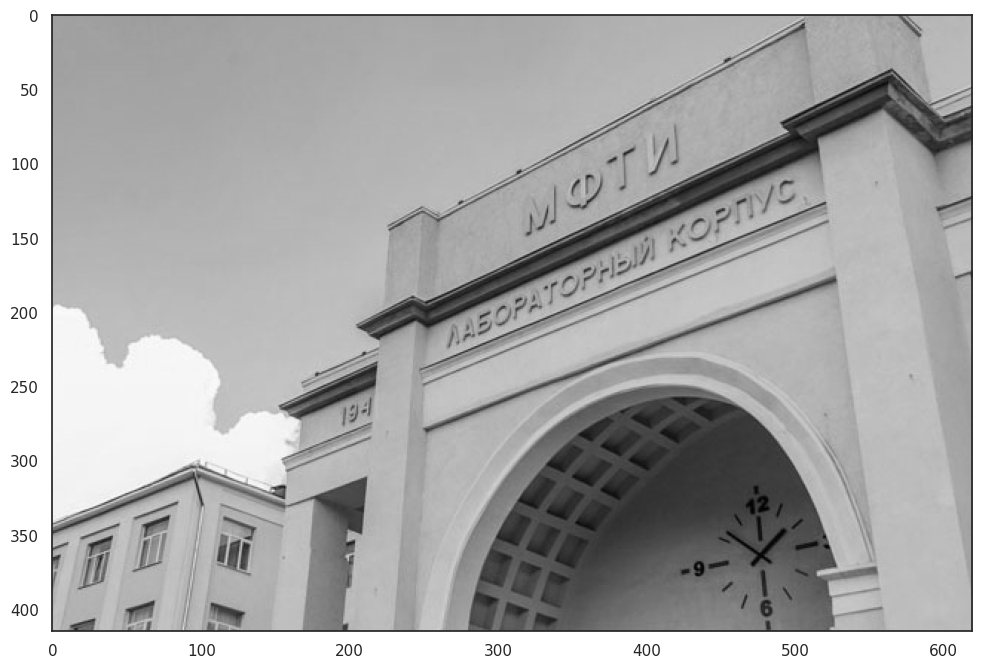

Б


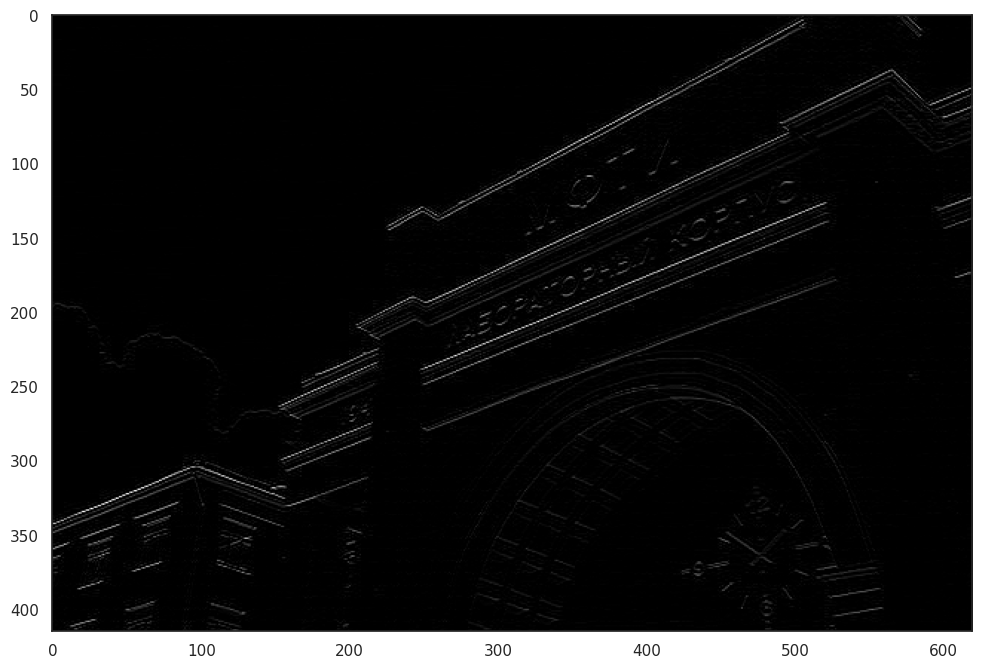

В


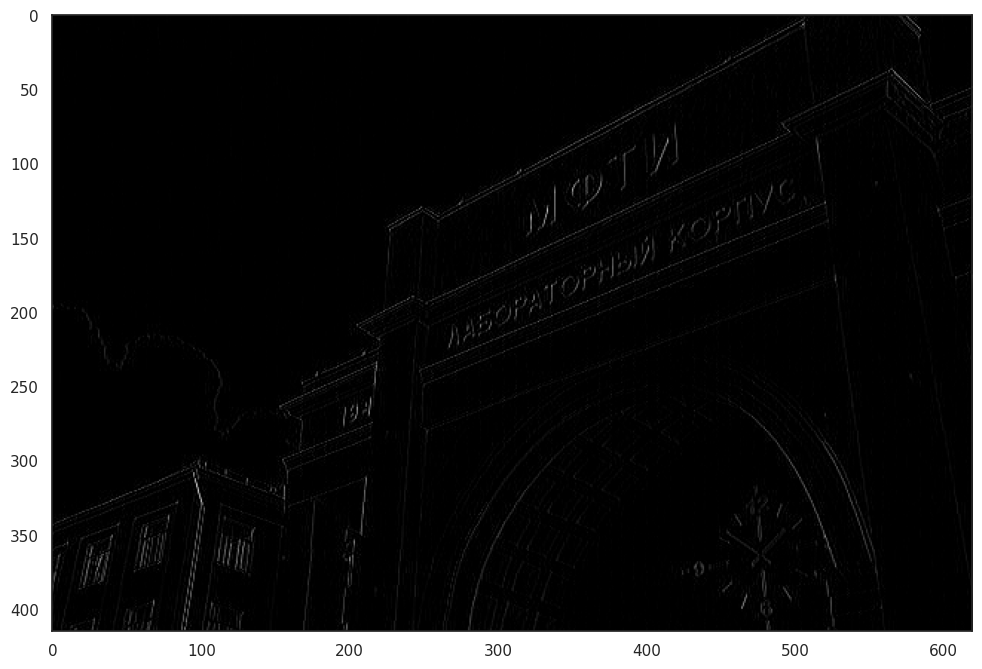

Г


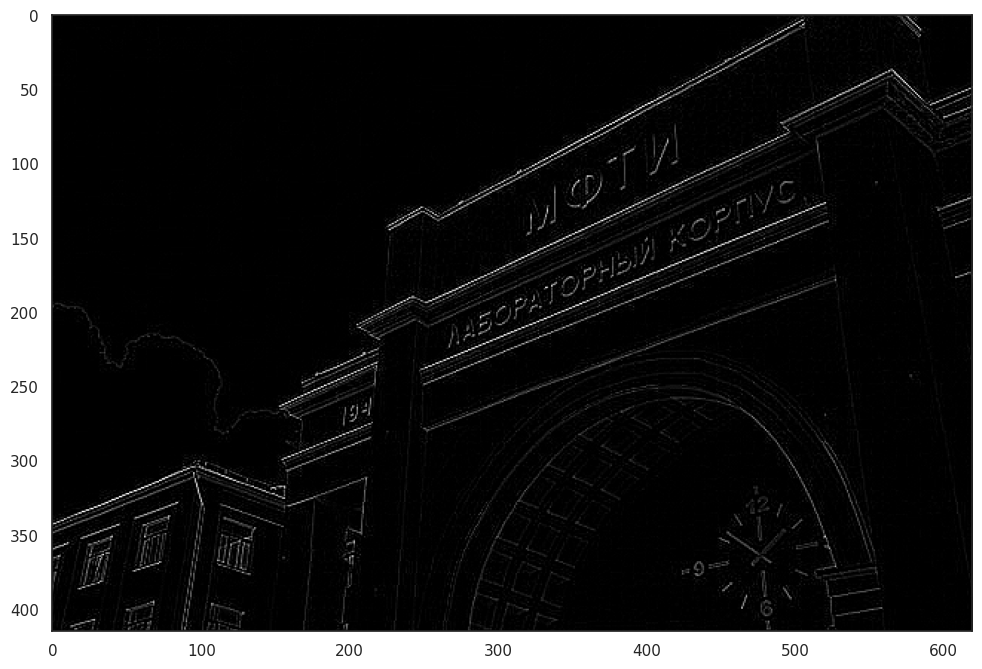

Д


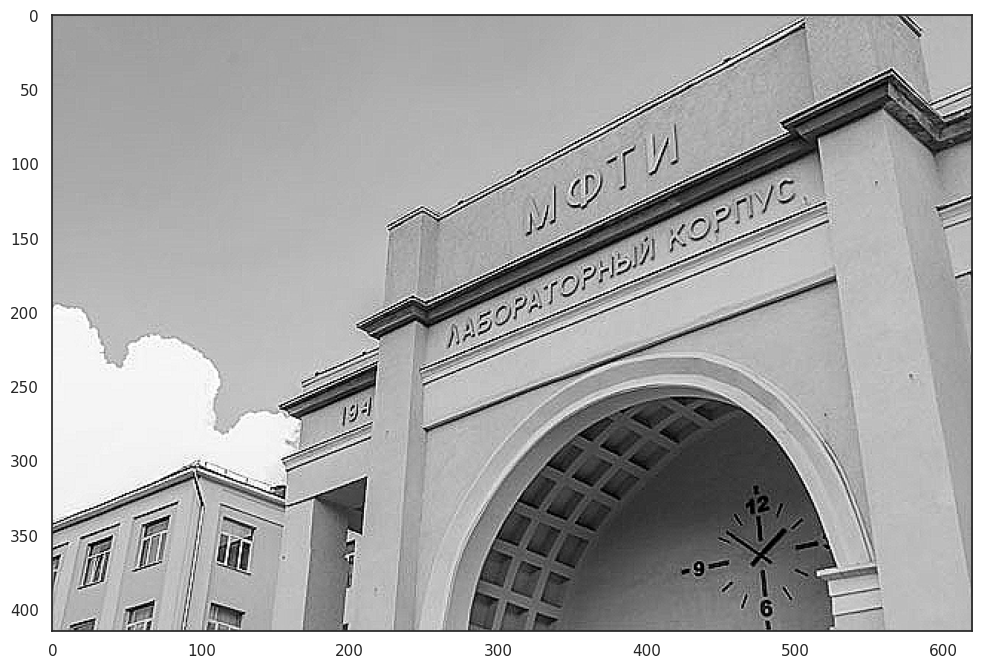

E


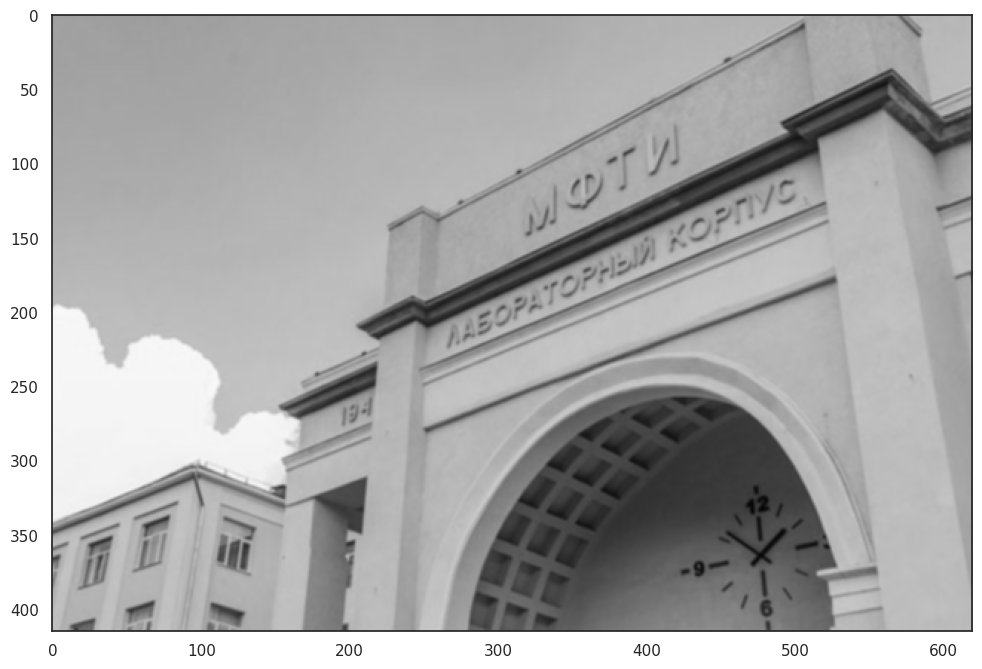

In [57]:
for k in kernels.items() : # Выведем все карты активации
  print(k[0])
  act_img = k[1]
  f(act_img)

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - E

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ Б

6) Выделение границ - Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [58]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6 , 16 , 3 )
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear( 5 * 5 * 16 , 120)
        self.fc2 = nn.Linear(120 , 84)
        self.fc3 = nn.Linear(84 , 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)



      
        x = self.flat(x)
        x = x.view(-1 , 5*5 * 16 )
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [59]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [ ], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
                 
            else:
                 model.eval()
                 with torch.no_grad(): 
                   outp = model(x_batch)
            
            preds = outp.argmax(-1)
            
           


            correct =  ( preds == y_batch).sum()

            
            all =  batch_size

            
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward() 
              optimizer.step() 
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9445166666666667
Loader: valid. Accuracy: 0.9733
Epoch: 2
Loader: train. Accuracy: 0.982
Loader: valid. Accuracy: 0.9816
Epoch: 3
Loader: train. Accuracy: 0.9864833333333334
Loader: valid. Accuracy: 0.9756
Epoch: 4
Loader: train. Accuracy: 0.9897
Loader: valid. Accuracy: 0.9868
Epoch: 5
Loader: train. Accuracy: 0.9912333333333333
Loader: valid. Accuracy: 0.9884
Epoch: 6
Loader: train. Accuracy: 0.9926166666666667
Loader: valid. Accuracy: 0.9885
Epoch: 7
Loader: train. Accuracy: 0.99415
Loader: valid. Accuracy: 0.9845
Epoch: 8
Loader: train. Accuracy: 0.9943833333333333
Loader: valid. Accuracy: 0.9888
Epoch: 9
Loader: train. Accuracy: 0.99515
Loader: valid. Accuracy: 0.987
Epoch: 10
Loader: train. Accuracy: 0.99595
Loader: valid. Accuracy: 0.9874


In [60]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

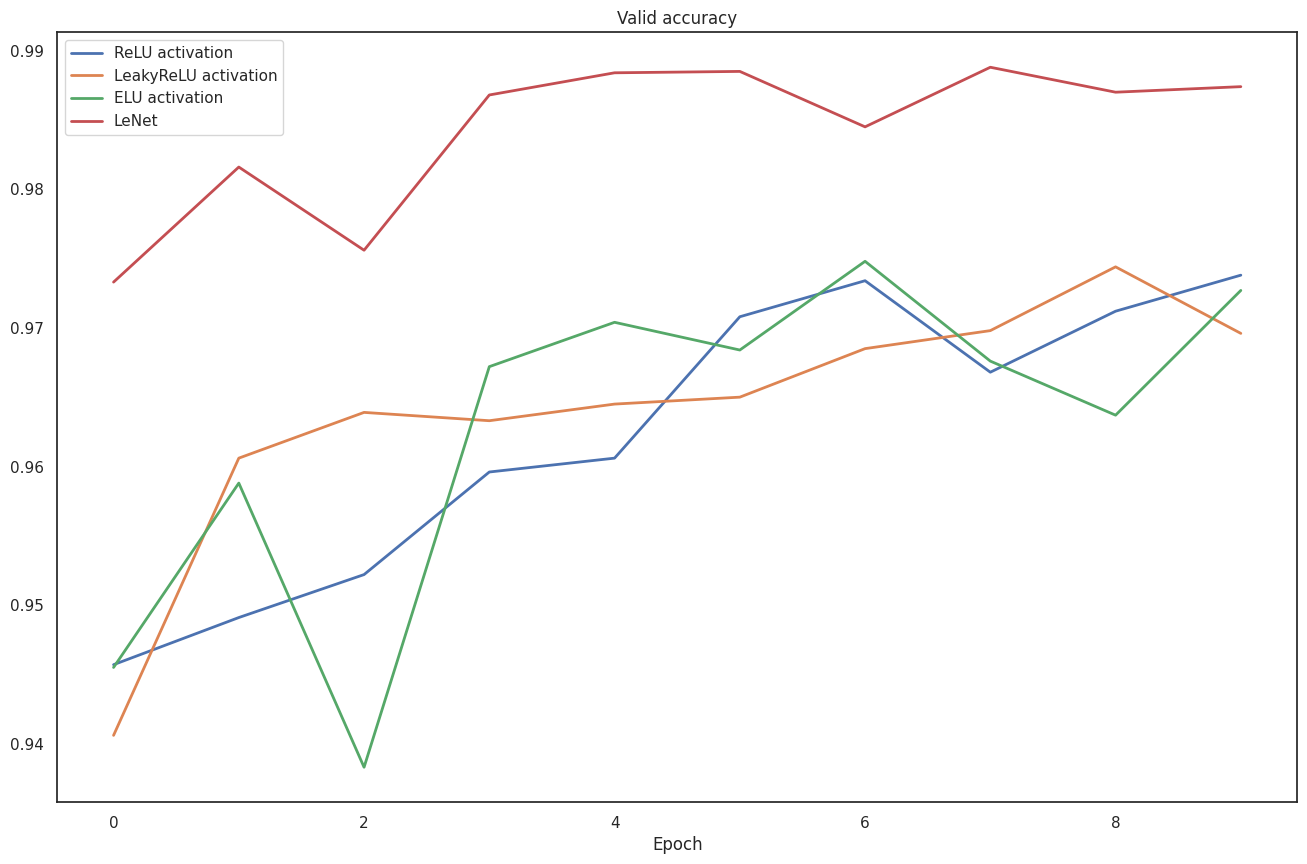

In [61]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

0.98

